In [6]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
from matplotlib import animation

PATH = '/home/emma/StudyGroup/'

# Alex's work 

Changed it all to pandas (removed A and I for one DataFrame called InfectedFarms) as I work better with a table, ignore if you prefer matrices

In [7]:
#Import Data
farmData = pd.read_csv(PATH +'Farms_2010_RSG', sep = '\s+', header = None, names = ['County Number', 'Parish Number', 'Holding Number',
                                                                              'X Coordinate', 'Y Coordinate', 'Number of Cattle', 
                                                                              'Number of Sheep'])
cumbData = farmData[farmData['County Number'] == 8]
cumbData = cumbData.reset_index(drop=True)
xCumb = cumbData['X Coordinate']/100000
yCumb = cumbData['Y Coordinate']/100000
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

In [8]:
#Calculate Euclidean distances
xinput = xcoord.values
yinput = ycoord.values
joinedinput = np.column_stack((xinput, yinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

In [9]:
#Parameter values
        
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 2.65
zeta = 1.80
chi = 0.403
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 30/39, N) #Draw infectious periods

t = 0
A = np.zeros(shape=(N,4))
output = np.zeros(shape=(N,6))
mycolumns = ['Farm Number', 'Status', 'Time of Exposure', 'Time of Culling',
                                       'Latent Period', 'Infectious Period', 'X coordinate', 'Y coordinate']
InfectedFarms  = pd.DataFrame(columns =mycolumns)

In [10]:
InfectedFarms['Farm Number']= cumbData.index                                                                                               
InfectedFarms['Status' ] = np.zeros(N)
InfectedFarms['Latent Period'] = s
InfectedFarms['Infectious Period'] = r
InfectedFarms['X coordinate'] = xinput
InfectedFarms['Y coordinate'] = yinput
InfectedFarms[['Time of Exposure', 'Time of Culling']]=[-100,-100]

In [11]:
#Calculate distance kernel
cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)
K = psi/(psi**2 + dist**2)

K[np.where(dist > 0.2)] = 0

beta1 = np.zeros(N)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)

In [12]:
#Choose initial case

initial1 = random.randint(0,N)
initial2=initial1+1
initial3=initial2+1
initial4=initial3+1

In [13]:
InfectedFarms.loc[initial1,['Status', 'Time of Exposure']] =[1,t]
InfectedFarms.loc[initial2,['Status', 'Time of Exposure']] =[1,t]
InfectedFarms.loc[initial3,['Status', 'Time of Exposure']] =[1,t]
InfectedFarms.loc[initial4,['Status', 'Time of Exposure']] =[1,t]

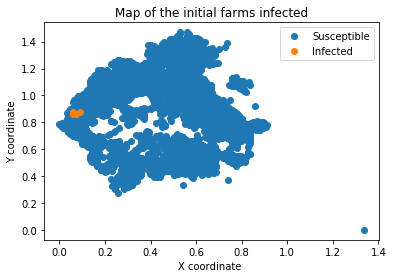

In [14]:
plt.plot(InfectedFarms['X coordinate'], InfectedFarms['Y coordinate'], 'o',label = 'Susceptible')
plt.plot(InfectedFarms[InfectedFarms['Status']==1]['X coordinate'], InfectedFarms[InfectedFarms['Status']==1]['Y coordinate'], 'o', label = 'Infected')
plt.legend(loc = 'upper right')
plt.xlabel('X coordinate ')
plt.ylabel('Y coordinate')
plt.title('Map of the initial farms infected')

farmr =  random.randint(0,N)

In [16]:
farmr =  random.randint(0,N)
num = 0
sum( (xinput[farmr]-xinput)**2 + (yinput[farmr] - yinput )**2 < 0.03**2)


array([0.0813 , 0.08963, 0.0948 , ..., 0.736  , 0.67827, 0.73999])

In [36]:
start_time = time.time()
IP = InfectedFarms['Status']
T = 0
while sum(IP == 1) + sum(IP == 2) > 0:
    T = T+1
    print("Day", T, "Exposed", sum(IP == 1), "Infected", sum(IP == 2), "Culled", sum(IP == 3))
    
    beta = np.zeros(N)
    for j in range(N):
        beta[j] = beta1[j]*(np.sum((zeta*(cattle[IP == 2]**chi) + sheep[IP == 2]**chi)*K[IP == 2, j]))  
    
    prob_inf = 1 - np.exp(-beta)
    unif = np.random.uniform(0, 1, N)
    for i in range(0,N):
        if (unif[i] <= prob_inf[i] and IP[i] == 0):
            InfectedFarms.loc[i,['Status', 'Time of Exposure']] =[1,T]
    
    InfectedFarms.loc[InfectedFarms['Time of Exposure']+InfectedFarms['Latent Period'] == T, 'Status'] =2

    InfectedFarms.loc[InfectedFarms['Time of Exposure']+
                      InfectedFarms['Latent Period'] + InfectedFarms['Infectious Period']==T, 'Status'] =3

    
    
print("--- %s seconds ---" % (time.time() - start_time))

Day 1 Exposed 4 Infected 0 Culled 0
Day 2 Exposed 4 Infected 0 Culled 0
Day 3 Exposed 4 Infected 0 Culled 0
Day 4 Exposed 4 Infected 0 Culled 0
Day 5 Exposed 3 Infected 1 Culled 0
Day 6 Exposed 1 Infected 3 Culled 0
Day 7 Exposed 1 Infected 3 Culled 0
Day 8 Exposed 1 Infected 3 Culled 0
3445
Day 9 Exposed 1 Infected 4 Culled 0
Day 10 Exposed 0 Infected 5 Culled 0
Day 11 Exposed 0 Infected 5 Culled 0
3249
3452
Day 12 Exposed 2 Infected 5 Culled 0
Day 13 Exposed 2 Infected 5 Culled 0
Day 14 Exposed 2 Infected 4 Culled 1
Day 15 Exposed 2 Infected 4 Culled 1
3262
Day 16 Exposed 3 Infected 4 Culled 1
Day 17 Exposed 1 Infected 5 Culled 2
Day 18 Exposed 1 Infected 4 Culled 3
Day 19 Exposed 0 Infected 4 Culled 4
3369
Day 20 Exposed 1 Infected 4 Culled 4
3246
Day 21 Exposed 2 Infected 3 Culled 5
Day 22 Exposed 2 Infected 3 Culled 5
Day 23 Exposed 2 Infected 2 Culled 6
Day 24 Exposed 1 Infected 3 Culled 6
Day 25 Exposed 1 Infected 3 Culled 6
Day 26 Exposed 1 Infected 3 Culled 6
Day 27 Exposed 1 

Day 207 Exposed 2 Infected 3 Culled 67
Day 208 Exposed 1 Infected 4 Culled 67
Day 209 Exposed 1 Infected 3 Culled 68
Day 210 Exposed 1 Infected 3 Culled 68
Day 211 Exposed 1 Infected 2 Culled 69
Day 212 Exposed 1 Infected 2 Culled 69
Day 213 Exposed 1 Infected 2 Culled 69
Day 214 Exposed 1 Infected 2 Culled 69
3342
Day 215 Exposed 2 Infected 1 Culled 70
Day 216 Exposed 1 Infected 2 Culled 70
Day 217 Exposed 1 Infected 2 Culled 70
Day 218 Exposed 1 Infected 2 Culled 70
Day 219 Exposed 1 Infected 2 Culled 70
Day 220 Exposed 0 Infected 3 Culled 70
Day 221 Exposed 0 Infected 2 Culled 71
3276
Day 222 Exposed 1 Infected 2 Culled 71
Day 223 Exposed 1 Infected 2 Culled 71
Day 224 Exposed 1 Infected 2 Culled 71
Day 225 Exposed 0 Infected 3 Culled 71
Day 226 Exposed 0 Infected 2 Culled 72
Day 227 Exposed 0 Infected 2 Culled 72
Day 228 Exposed 0 Infected 2 Culled 72
Day 229 Exposed 0 Infected 1 Culled 73
Day 230 Exposed 0 Infected 1 Culled 73
--- 347.3204565048218 seconds ---


# InP
This is a dataframe of just the farms that were infected. I add in aditional columns so I know the time exposed, infected and culled

In [41]:
InP = InfectedFarms[InfectedFarms['Time of Exposure']!=-100]
InP['Time of Infection'] = InP['Time of Exposure'] + InP['Latent Period']
InP['Time of Culling'] = InP['Time of Infection'] + InP['Infectious Period']

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Animation
If you would like the animation to be faster, increase fps

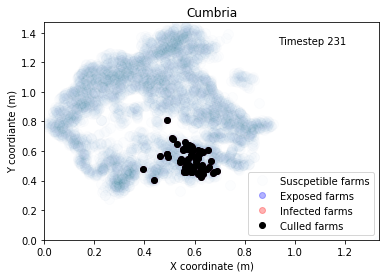

In [40]:
exposed = []
infect = []
culled = []

#appends each day (so that the classes can be colour coordinated)
for i in range(max(InP['Time of Culling'])+1):
    exposed.append(InP[InP['Time of Exposure'] <= i])
    infect.append(InP[InP['Time of Infection']<=i])
    culled.append(InP[InP['Time of Culling']<=i])

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
# All suscpetible farms initally
ax = plt.axes(xlim=(min(xcoord), max(xcoord)), 
              ylim=(min(ycoord), max(ycoord)))
ax.plot(xcoord, ycoord, 'o', alpha=.01, ms=10, label = 'Suscpetible farms')
line1, = ax.plot([], [], 'o', color = 'b', alpha = 0.3, label = 'Exposed farms')
line2,  = ax.plot([], [], 'o', color = 'r', alpha = 0.3, label = 'Infected farms')
line3,  = ax.plot([], [], 'o', color = 'k', alpha = 1, label = 'Culled farms')
time_text = ax.text(0.7, 0.9, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([],[])
    line3.set_data([],[])
    time_text.set_text('')
    return line1, line2, line3,

# animation function of dataframes' list
def animate(i):
    line1.set_data(exposed[i]['X coordinate'], exposed[i]['Y coordinate'])
    line2.set_data(infect[i]['X coordinate'], infect[i]['Y coordinate'])
    line3.set_data(culled[i]['X coordinate'], culled[i]['Y coordinate'])
    time_text.set_text('Timestep {}'.format(i+1))
    return line1, line2, line3, time_text

# call the animator, frames*(1/fps) is the speed of the animation.
# set number of frames to the length of your list of dataframes
anim = animation.FuncAnimation(fig, animate, frames=len(culled), init_func=init, interval=20, blit=True)
plt.legend(loc = 'lower right')
plt.title('Cumbria')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordiante (m)')
anim.save('FMD.mp4', fps=1.5)